# Random Graph Experimentation - Comparing RobustPC variants vs PC algorithm

We hypothesize that RobustPC in the context of **faithful** and/or **m-strong-faithful** graphs will perform better than the naive PC algorithm. The baseline CPDAG we want to compare to is the one using a ParentOracle, which is uniformly consistent for all graphs.

We have the following comparisons that leverage the momentary conditional independence condition (MCI), which leverages a fixed conditioning set in addition to that suggested via PC:

    - definite parents: Using a parent oracle
    - definite children: Using a children oracle
    - definite parents + definite children: Using a parent + children oracle
    - definite Markov blanket: Using the markov blanket oracle
    - estimated parents: using "some" procedure to estimate the parents
    - estimated parents + children: using "some" procedure to estimate the parents+children
    - estimated markov blanket: estimating the markov blanket
    
References
----------
[1] https://www.jmlr.org/papers/volume9/pellet08a/pellet08a.pdf

In [1]:
%load_ext lab_black

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
from pathlib import Path
from pprint import pprint
import json

import numpy as np
import bnlearn as bn
import networkx as nx
import pandas as pd

import causal_networkx
from causal_networkx.ci import (
    FisherZCITest,
    GSquareCITest,
    PartialCorrelation,
    Oracle,
    ParentOracle,
)
from causal_networkx.discovery import PC, RobustPC
from causal_networkx.io import read_dot, load_from_networkx

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
np.random.seed(12345)

# Set up to load the data

The data should have been previously generated via the manm_cs package for additive noise models. We will load the data in with specific parameters.

In [18]:
data_dir = Path("/Volumes/Extreme Pro/structure_learning_manm_sim")

In [22]:
n_datasets = len(list(data_dir.glob("*.csv")))
print(n_datasets)

899


In [118]:
ci_est = "parcorr"
ci_estimator = PartialCorrelation(method="pingouin")

# ci_est = "fisherz"
# ci_estimator = FisherZCITest()

In [119]:
for idx in range(n_datasets):
    data_fname = data_dir / f"graph_{idx}.csv"
    graph_fname = data_dir / f"graph_{idx}.gml"
    meta_fname = data_dir / f"graph_{idx}.json"

    if not data_fname.exists():
        continue
    # load the actual data
    df = pd.read_csv(data_fname, index_col=0)
    nx_graph = nx.read_gml(graph_fname)
    true_graph = load_from_networkx(nx_graph)
    with open(meta_fname, "r") as fin:
        meta_dict = json.load(fin)

    # sub-sample data
    df = df.sample(2000)

    # run the PC algorithm with Oracle
    oracle = Oracle(true_graph)
    pc_oracle = PC(ci_estimator=oracle)
    pc_oracle.fit(df)
    oracle_graph = pc_oracle.graph_
    fname = data_dir / "output" / f"graph_oracle_{ci_est}_{idx}.gml"
    oracle_graph.save(fname, format="networkx-gml")

    # run the PC algorithm with partial correlation
    pc_alg = PC(ci_estimator=ci_estimator)
    pc_alg.fit(df)
    pc_graph = pc_alg.graph_
    fname = data_dir / "output" / f"graph_pcalg_{ci_est}_{idx}.gml"
    pc_graph.save(fname, format="networkx-gml")

    # plt.figure()
    # pc_graph.draw()

    # run the RobustPC algorithm with partial correlation with ParentOracle
    partial_knowledge = ParentOracle(true_graph)
    robustpc = RobustPC(
        ci_estimator=ci_estimator,
        partial_knowledge=partial_knowledge,
        skip_first_stage=True,
        use_children=False,
    )

    robustpc.fit(df)
    graph = robustpc.graph_
    fname = data_dir / "output" / f"graph_robust_defparents_{ci_est}_{idx}.gml"
    graph.save(fname, format="networkx-gml")

    # plt.figure()
    # graph.draw()
    # run the RobustPC algorithm with partial correlation with ParentChildrenOracle
    partial_knowledge = ParentOracle(true_graph)
    robustpc = RobustPC(
        ci_estimator=ci_estimator,
        partial_knowledge=partial_knowledge,
        skip_first_stage=True,
        use_children=True,
    )
    robustpc.fit(df)
    graph = robustpc.graph_
    fname = data_dir / "output" / f"graph_robust_defparentschildren_{ci_est}_{idx}.gml"
    graph.save(fname, format="networkx-gml")

    # run the RobustPC algorithm with partial correlation with ParentChildrenOracle
    # partial_knowledge = ParentOracle(true_graph)
    # robustpc = RobustPC(ci_estimator=parcorr.test,
    #                    partial_knowledge=partial_knowledge,
    #                    skip_first_stage=True,)

    # true_graph.draw()
    # print(true_graph)
    # print(meta_dict)
    # break

898
79.0
92.0


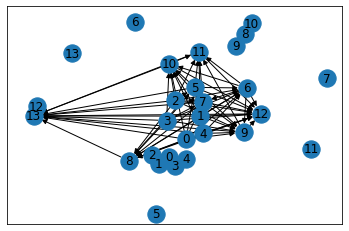

In [90]:
oracle_graph.draw()
print(idx)
print(structure_hamming_dist(oracle_graph, pc_graph))
print(structure_hamming_dist(oracle_graph, graph))

In [14]:
print(df.shape)
df = df.sample(2000)
print(df.shape)
display(df.head())
print(true_graph.nodes)

(2000, 8)
(2000, 8)


,0,1,3,2,4,5,6,7
40637,0.014364,0.024058,-0.016820,-0.046680,0.057558,0.202271,0.016930,0.344551
49058,-0.167264,-0.034615,0.133145,0.015786,-0.085946,-0.073792,-0.004761,-0.074673
8357,-0.058759,-0.042129,0.139892,0.183159,-0.021755,-0.188475,-0.053988,-0.153292
15264,-0.050388,0.113370,0.117130,0.075717,0.016816,-0.017718,0.008593,0.045114
46025,0.089779,0.127293,-0.043437,-0.005178,-0.047214,-0.127905,-0.089685,-0.147618


['0', '1', '2', '3', '4', '5', '6', '7']


In [26]:
print(true_graph.edges)

[('0', '1'), ('0', '2'), ('0', '3'), ('0', '4'), ('0', '5'), ('0', '6'), ('0', '7'), ('0', '8'), ('0', '9'), ('0', '10'), ('0', '12'), ('0', '13'), ('1', '2'), ('1', '3'), ('1', '6'), ('1', '8'), ('1', '9'), ('1', '10'), ('1', '11'), ('1', '12'), ('1', '13'), ('2', '5'), ('2', '6'), ('2', '7'), ('2', '8'), ('2', '9'), ('2', '10'), ('2', '11'), ('2', '12'), ('2', '13'), ('3', '4'), ('3', '5'), ('3', '6'), ('3', '7'), ('3', '8'), ('3', '9'), ('3', '10'), ('3', '12'), ('3', '13'), ('4', '5'), ('4', '6'), ('4', '7'), ('4', '8'), ('4', '9'), ('4', '10'), ('4', '12'), ('4', '13'), ('5', '6'), ('5', '7'), ('5', '8'), ('5', '9'), ('5', '10'), ('5', '11'), ('5', '12'), ('5', '13'), ('6', '7'), ('6', '8'), ('6', '9'), ('6', '10'), ('6', '11'), ('6', '12'), ('7', '8'), ('7', '9'), ('7', '10'), ('7', '11'), ('7', '12'), ('7', '13'), ('8', '9'), ('8', '10'), ('8', '12'), ('8', '13'), ('9', '11'), ('9', '12'), ('9', '13'), ('10', '11'), ('10', '12'), ('10', '13'), ('11', '12'), ('11', '13'), ('12', 

# Analyze Different Algorithms

For every graph, re-load in the graphs that were learned and compare against the benchmark: the Oracle setting.

Use the confusion matrix and ROC_auc.

In [120]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score

from causal_networkx.io import read_gml
from causal_networkx.metrics import structure_hamming_dist, graph_to_pred_vector

In [122]:
ci_est = "parcorr"

In [123]:
perf_df = pd.DataFrame()

for idx in range(n_datasets):
    # load the metadata
    meta_fname = data_dir / f"graph_{idx}.json"
    if not meta_fname.exists():
        continue
    with open(meta_fname, "r") as fin:
        meta_dict = json.load(fin)

    # load the oracle
    oracle_graph_fname = data_dir / "output" / f"graph_oracle_{ci_est}_{idx}.gml"
    oracle_graph = read_gml(oracle_graph_fname)

    perf_dict = meta_dict.copy()
    perf_dict["n_edges"] = oracle_graph.to_adjacency_graph().number_of_edges()

    for name in ["pcalg", "robust_defparents", "robust_defparentschildren"]:
        graph_fname = data_dir / "output" / f"graph_{name}_{ci_est}_{idx}.gml"

        # load in the graph
        graph = read_gml(graph_fname)

        # compare the graphs
        shd = structure_hamming_dist(oracle_graph, graph)
        perf_dict[f"shd-{name}"] = shd

        # compute true positive rate and false positive rate
        oracle_vec = graph_to_pred_vector(oracle_graph)
        graph_vec = graph_to_pred_vector(graph)

        ppv = precision_score(oracle_vec, graph_vec, pos_label=1)
        npv = precision_score(oracle_vec, graph_vec, pos_label=0)
        perf_dict[f"ppv-{name}"] = ppv
        perf_dict[f"npv-{name}"] = npv

        tpr = recall_score(oracle_vec, graph_vec, pos_label=1)
        fpr = recall_score(oracle_vec, graph_vec, pos_label=0)
        perf_dict[f"tpr-{name}"] = tpr
        perf_dict[f"fpr-{name}"] = fpr

    _perf_df = pd.DataFrame.from_dict(perf_dict)
    perf_df = pd.concat((perf_df, _perf_df))
display(perf_df.head())
# break

,idx,n_nodes,n_samples,edge_density,discrete_node_ratio,conditional_gaussian,discrete_signal_to_noise_ratio,min_discrete_value_classes,max_discrete_value_classes,continuous_noise_std,...,shd-robust_defparents,ppv-robust_defparents,npv-robust_defparents,tpr-robust_defparents,fpr-robust_defparents,shd-robust_defparentschildren,ppv-robust_defparentschildren,npv-robust_defparentschildren,tpr-robust_defparentschildren,fpr-robust_defparentschildren
0,0,5,500000,0.1,0.0,True,0.9,3,4,0.100000,...,1.0,0.0,1.0,0.0,0.9,1.0,0.0,1.0,0.0,0.9
0,1,5,500000,0.1,0.0,True,0.9,3,4,0.422222,...,2.0,0.0,1.0,0.0,0.8,2.0,0.0,1.0,0.0,0.8
0,2,5,500000,0.1,0.0,True,0.9,3,4,0.744444,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
0,3,5,500000,0.1,0.0,True,0.9,3,4,1.066667,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
0,4,5,500000,0.1,0.0,True,0.9,3,4,1.388889,...,1.0,0.0,1.0,0.0,0.9,1.0,0.0,1.0,0.0,0.9


In [136]:
from pprint import pprint

pprint(perf_df.columns)

Index(['Unnamed: 0', 'idx', 'n_nodes', 'n_samples', 'edge_density',
       'discrete_node_ratio', 'conditional_gaussian',
       'discrete_signal_to_noise_ratio', 'min_discrete_value_classes',
       'max_discrete_value_classes', 'continuous_noise_std',
       'beta_lower_limit', 'beta_upper_limit', 'functions_prob', 'functions',
       'n_edges', 'shd-pcalg', 'ppv-pcalg', 'npv-pcalg', 'tpr-pcalg',
       'fpr-pcalg', 'shd-robust_defparents', 'ppv-robust_defparents',
       'npv-robust_defparents', 'tpr-robust_defparents',
       'fpr-robust_defparents', 'shd-robust_defparentschildren',
       'ppv-robust_defparentschildren', 'npv-robust_defparentschildren',
       'tpr-robust_defparentschildren', 'fpr-robust_defparentschildren',
       'shd-diff', 'fpr-diff', 'tpr-diff', 'ppv-diff', 'npv-diff'],
      dtype='object')


In [124]:
fname = data_dir / "summary" / f"performance_summary_{ci_est}_850_runs.csv"
fname.parent.mkdir(exist_ok=True, parents=True)
perf_df.to_csv(fname)

print(perf_df.shape)

(898, 30)


In [130]:
ci_est = "fisherz"
fname = data_dir / "summary" / f"performance_summary_{ci_est}_850_runs.csv"
perf_df = pd.read_csv(fname)

In [131]:
perf_df["shd-diff"] = perf_df["shd-robust_defparents"] - perf_df["shd-pcalg"]

[Text(0.5, 1.0, 'shd of Detection of Edges'),
 Text(0.5, 0, 'Number of nodes'),
 Text(0, 0.5, '$\\Delta$-shd \n(Robust-DefParents - PC)')]

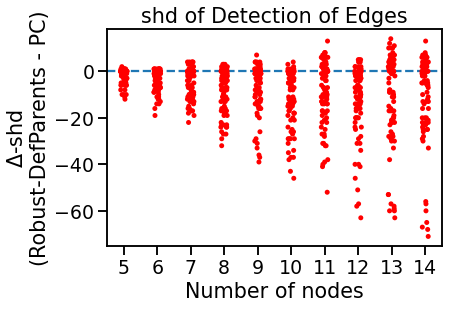

In [132]:
metric = "shd"
perf_df[f"{metric}-diff"] = (
    perf_df[f"{metric}-robust_defparents"] - perf_df[f"{metric}-pcalg"]
)
sns.set_context("talk", font_scale=1.15)

fig, ax = plt.subplots()
sns.stripplot(x="n_nodes", y=f"{metric}-diff", color="red", data=perf_df, ax=ax)
ax.axhline([0], ls="--")

ax.set(
    title=f"{metric} of Detection of Edges",
    xlabel="Number of nodes",
    ylabel=f"$\Delta$-{metric} \n(Robust-DefParents - PC)",
)

[Text(0.5, 1.0, 'fpr of Detection of Edges'),
 Text(0.5, 0, 'Number of nodes'),
 Text(0, 0.5, '$\\Delta$-fpr \n(Robust-DefParents - PC)')]

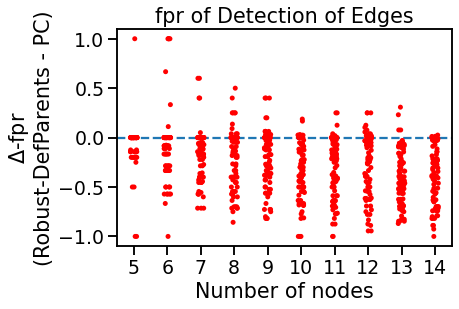

In [133]:
metric = "fpr"
perf_df[f"{metric}-diff"] = (
    perf_df[f"{metric}-robust_defparents"] - perf_df[f"{metric}-pcalg"]
)
sns.set_context("talk", font_scale=1.15)

fig, ax = plt.subplots()
sns.stripplot(x="n_nodes", y=f"{metric}-diff", color="red", data=perf_df, ax=ax)
ax.axhline([0], ls="--")

ax.set(
    title=f"{metric} of Detection of Edges",
    xlabel="Number of nodes",
    ylabel=f"$\Delta$-{metric} \n(Robust-DefParents - PC)",
)

### Discussion Notes 6/17/22 w/ Adele:

For all metrics (fpr/tpr/shd), we need to investigate based on fixing the #edge (or edge_density):

- # nodes == 5, looking at Delta-FPR == 1.0, what is going on for example there?
- investigate confounding of the 'edge_density', by showing 9 plots of 0.1-0.9 of the plots
    - also show later that increasing the sample size, for a fixed set of nodes and edge density, that we are "improving" and obtaining statistical consistency
- Also check if conditioning on ancestors is fine (random sampling e.g. 3 ancestors).
- what is the decrease/increase in performance by adding the children?
    
For new results, we want to investigate "how to estimate the parents", to make these results work in practice:

#### Background knowledge
- partial/ancestral order (non-ancestor, possible/potential-ancestor, definite-ancestor, definite non-descendant, ): 
    - something to check: conditioning on a neighbor that is connected by bidirected edge in FCI-algorithm, is this a problem? Since conditioning on children probably decreases performance.
    - E.g. in an adjacency discovery phase, adjacent variables can be: i) parent/child, ii) (in semi-markovian case) ancestor/descendant, or iii) (in semi-markovian case) bidirected edge.
    
Example: Definite non-descendant knowledge of B is definitely non-descendant of A, in PAG during middle of FCI. Say the variables, {A, B} are adjacent, then B *-> A, where it could mean: B -> A, or B <-> A. Note in the case of Markovian, it would definitely be B -> A.
    
#### More data
- using interventions: to estimate ancestral/descendant relationships
    - E.g. inversion of R3 of do-calc is related to partial order
        - if y is before 'x' and you intervene on 'x', then if R3 applies, then you would see that y has "no response" relative to the intervention of 'x'.
        - TODO: re-read Amin's paper, on what is said about R2/3.
        - TODO: think about some examples, where the R2/3 gives us more than just CI we get some partial knowledge
        - 'x' <- 'y': now if we intervene on 'x', then P(y | do(x)) = P(y) under R3
            - 'x' <--> 'y' or 'x' 'y'
            - in english: 'y' is not a descendant of 'x' and we "see" this after some intervention.
        - 'x' <- 'y' <- 'z': now if we intervene on 'x', then P(y | do(x), z) = P(y | z) under R3
        - 'z' <- 'x' <- 'y',:  now if we intervene on 'x', then P(y | do(x)) = P(y) under R3, but also P(z | do(x)) \neq P(z)
        - in semi-markov: if 'z' is a collider...

#### Iterations of algorithm(s):
- running PC algorithm multiple times
- score-based algorithms

[Text(0.5, 1.0, 'tpr of Detection of Edges'),
 Text(0.5, 0, 'Number of nodes'),
 Text(0, 0.5, '$\\Delta$-tpr \n(Robust-DefParents - PC)')]

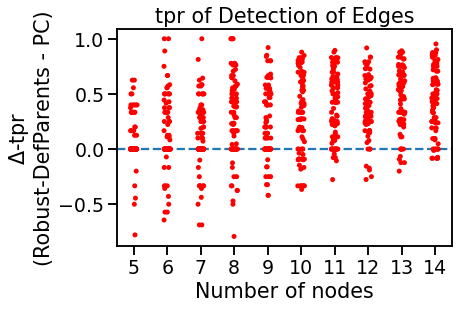

In [134]:
metric = "tpr"
perf_df[f"{metric}-diff"] = (
    perf_df[f"{metric}-robust_defparents"] - perf_df[f"{metric}-pcalg"]
)
sns.set_context("talk", font_scale=1.15)

fig, ax = plt.subplots()
sns.stripplot(x="n_nodes", y=f"{metric}-diff", color="red", data=perf_df, ax=ax)
ax.axhline([0], ls="--")

ax.set(
    title=f"{metric} of Detection of Edges",
    xlabel="Number of nodes",
    ylabel=f"$\Delta$-{metric} \n(Robust-DefParents - PC)",
)

[Text(0.5, 1.0, 'npv of Detection of Edges'),
 Text(0.5, 0, 'Number of nodes'),
 Text(0, 0.5, '$\\Delta$-npv \n(Robust-DefParents - PC)')]

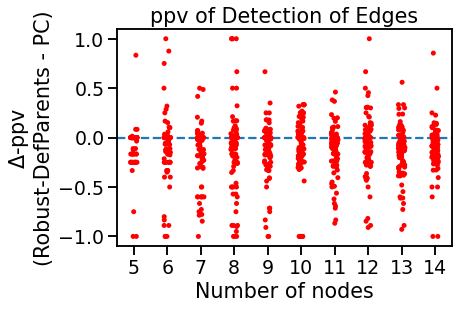

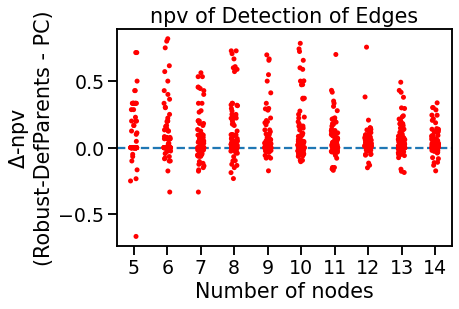

In [135]:
metric = "ppv"
perf_df[f"{metric}-diff"] = (
    perf_df[f"{metric}-robust_defparents"] - perf_df[f"{metric}-pcalg"]
)
sns.set_context("talk", font_scale=1.15)

fig, ax = plt.subplots()
sns.stripplot(x="n_nodes", y=f"{metric}-diff", color="red", data=perf_df, ax=ax)
ax.axhline([0], ls="--")

ax.set(
    title=f"{metric} of Detection of Edges",
    xlabel="Number of nodes",
    ylabel=f"$\Delta$-{metric} \n(Robust-DefParents - PC)",
)

metric = "npv"
perf_df[f"{metric}-diff"] = (
    perf_df[f"{metric}-robust_defparents"] - perf_df[f"{metric}-pcalg"]
)
sns.set_context("talk", font_scale=1.15)

fig, ax = plt.subplots()
sns.stripplot(x="n_nodes", y=f"{metric}-diff", color="red", data=perf_df, ax=ax)
ax.axhline([0], ls="--")

ax.set(
    title=f"{metric} of Detection of Edges",
    xlabel="Number of nodes",
    ylabel=f"$\Delta$-{metric} \n(Robust-DefParents - PC)",
)